In [ ]:
!pip install pydub

In [ ]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers, regularizers, optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten, Bidirectional,  MultiHeadAttention, Conv1D, MaxPooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.pyplot as plt
from pydub import AudioSegment
from tensorflow.keras.layers.experimental import preprocessing


In [ ]:
# Function to load data from folder
def load_data_from_folder(folder):
    labels = []
    data = []

    for subdir, _, files in os.walk(folder):
        for file in files:
            if file.endswith(".npy"):
                file_path = os.path.join(subdir, file)
                label = os.path.basename(subdir)  # Use the parent folder name as the label
                labels.append(label)
                data.append(np.load(file_path))

    return np.array(data), np.array(labels)

# Specify the root folder containing subdirectories with .npy files
root_folder = "/content/drive/MyDrive/MFCC_Features"

# Load data from subdirectories
data, labels = load_data_from_folder(root_folder)

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)
encoded_labels = to_categorical(encoded_labels, num_classes=num_classes)

# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    data, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels
)

# Data normalization using TensorFlow preprocessing layers
normalization_layer = preprocessing.Normalization()
normalization_layer.adapt(X_train)  # Compute mean and variance based on training data
X_train_normalized = normalization_layer(X_train)
X_test_normalized = normalization_layer(X_test)

# Data augmentation using TensorFlow preprocessing layers
data_augmentation = Sequential([
    preprocessing.Rescaling(1./255),  # Normalize pixel values to [0,1]
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
])

X_train_augmented = data_augmentation(X_train_normalized)
X_test_augmented = data_augmentation(X_test_normalized)

# Compute class weights for handling class imbalance
class_weights = compute_class_weight("balanced", classes=np.unique(encoded_labels.argmax(axis=1)), y=encoded_labels.argmax(axis=1))
class_weight_dict = dict(zip(np.unique(encoded_labels.argmax(axis=1)), class_weights))


STARTING MFFC Feature TRAINING FROM HERE

In [ ]:
model = Sequential()
model.add(LSTM(64, input_shape=(X_train_augmented.shape[1], X_train_augmented.shape[2]), return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(64, return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(64))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))


# Use the Adam optimizer for better convergence
optimizer = Adam(learning_rate=0.0001)

# Compile the model with categorical_crossentropy loss and accuracy metric
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model with a more expressive variable name for clarity
epochs = 10
batch_size = 22
validation_data = (X_test_augmented, y_test)

history = model.fit(X_train_augmented, y_train, epochs=epochs, batch_size=batch_size, validation_data=validation_data)

# Plot training history
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training acc')  # Use 'b-' for solid blue line
    plt.plot(epochs, val_acc, 'r-', label='Validation acc')  # Use 'r-' for solid red line
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training loss')  # Use 'b-' for solid blue line
    plt.plot(epochs, val_loss, 'r-', label='Validation loss')  # Use 'r-' for solid red line
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the function to plot the training history
plot_training_history(history)
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy*100:.2f}%")

NameError: ignored

In [ ]:
import os
import librosa
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LSTM, Flatten, concatenate
from keras.optimizers import Adam

# Function to load audio files and extract MFCC features
def load_and_process_data(root_folder):
    all_long_term_features = []
    all_short_term_features = []
    all_labels = []

    for dirpath, dirnames, filenames in os.walk(root_folder):
        for filename in filenames:
            if filename.endswith('.wav'):
                file_path = os.path.join(dirpath, filename)

                # Load an audio file
                audio_data, sr = librosa.load(file_path, sr=None)

                # MFCC Feature Extraction
                mfcc_features = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=13)

                # Split MFCC features into long-term and short-term features
                long_term_features = mfcc_features[:, :100]  # Adjust the frame range as needed
                short_term_features = mfcc_features[:, 100:]

                # Add the features to the lists
                all_long_term_features.append(long_term_features.T)
                all_short_term_features.append(short_term_features.T[:, :, np.newaxis])

                # Extract label information from the directory structure or filenames
                label = extract_label_from_filename(filename)
                all_labels.append(label)

    # Convert lists to numpy arrays
    X_long_term = np.concatenate(all_long_term_features, axis=0)
    X_short_term = np.concatenate(all_short_term_features, axis=0)
    y = np.array(all_labels)

    return X_long_term, X_short_term, y

# Example function to extract label from filename
def extract_label_from_filename(filename):
    # Assuming labels are the first part of the filename
    label = filename.split('_')[0]
    return label

# Assume you have a function that preprocesses and one-hot encodes your labels (preprocess_labels)
# Replace it with your actual preprocessing logic
def preprocess_labels(y):
    unique_labels = np.unique(y)
    label_to_index = {label: i for i, label in enumerate(unique_labels)}
    y_one_hot = np.zeros((len(y), len(unique_labels)))
    for i, label in enumerate(y):
        y_one_hot[i, label_to_index[label]] = 1
    return y_one_hot

# Set your root folder
root_folder = '/content/drive/MyDrive/Removed_Pauses'

num_classes = 15

# Load and preprocess data
X_long_term, X_short_term, y = load_and_process_data(root_folder)
y = preprocess_labels(y)

# Build the DNN model for long-term features
dnn_model = Sequential()
dnn_model.add(Dense(64, activation='relu', input_shape=(X_long_term.shape[1],)))
dnn_model.add(Dense(128, activation='relu'))
dnn_model.add(Dense(num_classes, activation='softmax'))

# Build the RNN model for short-term features
rnn_model = Sequential()
rnn_model.add(LSTM(64, input_shape=(X_short_term.shape[1], 1)))  # Assumes 1 feature per time step
rnn_model.add(Dense(num_classes, activation='softmax'))

# Concatenate the outputs of the DNN and RNN models
combined_input = concatenate([dnn_model.output, rnn_model.output])

# Add a Dense layer for further processing
combined_model = Dense(128, activation='relu')(combined_input)
combined_model = Dense(num_classes, activation='softmax')(combined_model)

# Create the final model
final_model = Model(inputs=[dnn_model.input, rnn_model.input], outputs=combined_model)

# Compile the model
final_model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Example: Assuming you have labels (y) for your audio data
# Replace 'y' with your actual labels and preprocess the data as needed
y = np.random.randint(0, 2, size=(X_long_term.shape[0], num_classes))

# Train the model
final_model.fit([X_long_term, X_short_term], y, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
3335/3335 [==============================] - 43s 12ms/step - loss: 21.7110 - accuracy: 0.1301 - val_loss: 21.5102 - val_accuracy: 0.0300
Epoch 2/10
3335/3335 [==============================] - 37s 11ms/step - loss: 21.7178 - accuracy: 0.1136 - val_loss: 22.8003 - val_accuracy: 6.7466e-04
Epoch 3/10
3335/3335 [==============================] - 39s 12ms/step - loss: 21.8078 - accuracy: 0.1164 - val_loss: 21.2363 - val_accuracy: 0.0614
Epoch 4/10
3335/3335 [==============================] - 37s 11ms/step - loss: 22.1311 - accuracy: 0.1047 - val_loss: 22.7045 - val_accuracy: 6.7466e-04
Epoch 5/10
3335/3335 [==============================] - 37s 11ms/step - loss: 22.4393 - accuracy: 0.0918 - val_loss: 21.0977 - val_accuracy: 0.5011
Epoch 6/10
3335/3335 [==============================] - 39s 12ms/step - loss: 22.7258 - accuracy: 0.0925 - val_loss: 22.8670 - val_accuracy: 0.0300
Epoch 7/10
3335/3335 [==============================] - 39s 12ms/step - loss: 23.1451 - accuracy: 0.0780

In [ ]:
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy*100:.2f}%")

NameError: ignored

Epoch 1/10
34/34 [==============================] - 8s 60ms/step - loss: 2.3804 - accuracy: 0.4221 - val_loss: 2.1342 - val_accuracy: 0.4345
Epoch 2/10
34/34 [==============================] - 1s 25ms/step - loss: 2.1375 - accuracy: 0.4343 - val_loss: 2.0790 - val_accuracy: 0.4345
Epoch 3/10
34/34 [==============================] - 1s 25ms/step - loss: 2.1481 - accuracy: 0.4343 - val_loss: 2.0787 - val_accuracy: 0.4345
Epoch 4/10
34/34 [==============================] - 1s 26ms/step - loss: 2.1188 - accuracy: 0.4343 - val_loss: 2.0807 - val_accuracy: 0.4345
Epoch 5/10
34/34 [==============================] - 1s 27ms/step - loss: 2.1347 - accuracy: 0.4343 - val_loss: 2.0802 - val_accuracy: 0.4345
Epoch 6/10
34/34 [==============================] - 1s 25ms/step - loss: 2.1164 - accuracy: 0.4343 - val_loss: 2.0841 - val_accuracy: 0.4345
Epoch 7/10
34/34 [==============================] - 1s 25ms/step - loss: 2.1121 - accuracy: 0.4343 - val_loss: 2.0778 - val_accuracy: 0.4345
Epoch 8/10
34

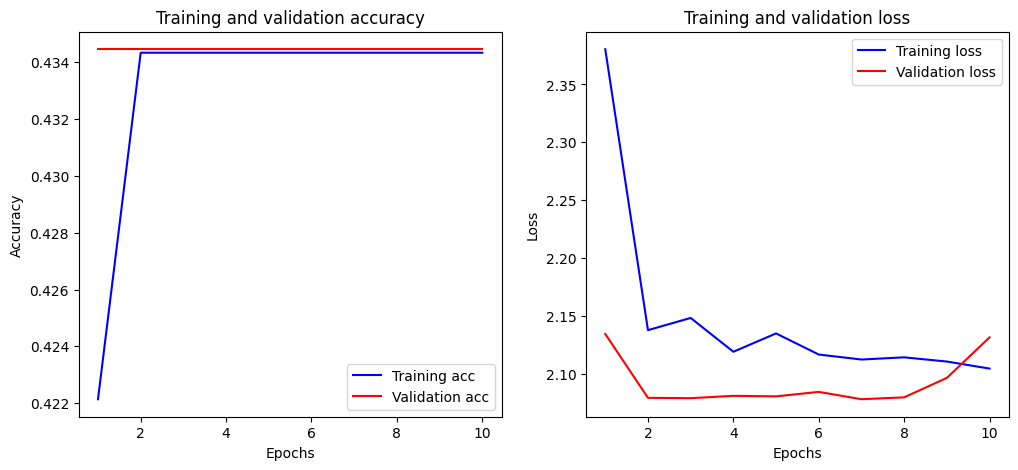

9/9 [==============================] - 0s 10ms/step - loss: 2.2493 - accuracy: 0.4382
Test Loss: 2.2493, Test Accuracy: 43.82%


In [ ]:
# Build the LSTM model with added bidirectional layers for better performance
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train_augmented.shape[1], X_train_augmented.shape[2])))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Use the Adam optimizer for better convergence
optimizer = Adam(learning_rate=0.001)

# Compile the model with categorical_crossentropy loss and accuracy metric
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model with a more expressive variable name for clarity
epochs = 10
batch_size = 32
validation_data = (X_test_augmented, y_test)

history = model.fit(X_train_augmented, y_train, epochs=epochs, batch_size=batch_size, validation_data=validation_data)

# Plot training history
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training acc')  # Use 'b-' for solid blue line
    plt.plot(epochs, val_acc, 'r-', label='Validation acc')  # Use 'r-' for solid red line
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training loss')  # Use 'b-' for solid blue line
    plt.plot(epochs, val_loss, 'r-', label='Validation loss')  # Use 'r-' for solid red line
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the function to plot the training history
plot_training_history(history)
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy*100:.2f}%")


Epoch 1/10
34/34 [==============================] - 8s 59ms/step - loss: 2.3942 - accuracy: 0.4231 - val_loss: 2.1707 - val_accuracy: 0.4345
Epoch 2/10
34/34 [==============================] - 1s 39ms/step - loss: 2.1159 - accuracy: 0.4343 - val_loss: 2.0858 - val_accuracy: 0.4345
Epoch 3/10
34/34 [==============================] - 1s 41ms/step - loss: 2.0933 - accuracy: 0.4343 - val_loss: 2.0799 - val_accuracy: 0.4345
Epoch 4/10
34/34 [==============================] - 1s 26ms/step - loss: 2.1194 - accuracy: 0.4343 - val_loss: 2.0806 - val_accuracy: 0.4345
Epoch 5/10
34/34 [==============================] - 1s 25ms/step - loss: 2.1023 - accuracy: 0.4343 - val_loss: 2.0786 - val_accuracy: 0.4345
Epoch 6/10
34/34 [==============================] - 1s 25ms/step - loss: 2.0934 - accuracy: 0.4343 - val_loss: 2.0815 - val_accuracy: 0.4345
Epoch 7/10
34/34 [==============================] - 1s 24ms/step - loss: 2.1106 - accuracy: 0.4343 - val_loss: 2.0791 - val_accuracy: 0.4345
Epoch 8/10
34

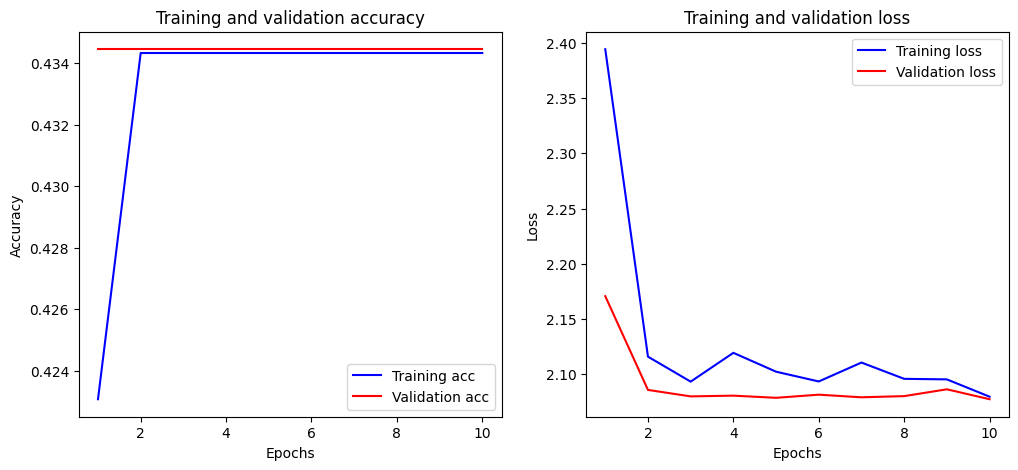

9/9 [==============================] - 0s 8ms/step - loss: 2.4306 - accuracy: 0.3858
Test Loss: 2.4306, Test Accuracy: 38.58%


In [ ]:
#Changing the Dropout
# Build the LSTM model with added bidirectional layers for better performance
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train_augmented.shape[1], X_train_augmented.shape[2])))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

# Use the Adam optimizer for better convergence
optimizer = Adam(learning_rate=0.001)

# Compile the model with categorical_crossentropy loss and accuracy metric
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model with a more expressive variable name for clarity
epochs = 10
batch_size = 32
validation_data = (X_test_augmented, y_test)

history = model.fit(X_train_augmented, y_train, epochs=epochs, batch_size=batch_size, validation_data=validation_data)

# Plot training history
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training acc')  # Use 'b-' for solid blue line
    plt.plot(epochs, val_acc, 'r-', label='Validation acc')  # Use 'r-' for solid red line
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training loss')  # Use 'b-' for solid blue line
    plt.plot(epochs, val_loss, 'r-', label='Validation loss')  # Use 'r-' for solid red line
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the function to plot the training history
plot_training_history(history)
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy*100:.2f}%")


Epoch 1/10
34/34 [==============================] - 9s 84ms/step - loss: 2.3721 - accuracy: 0.4156 - val_loss: 2.0868 - val_accuracy: 0.4345
Epoch 2/10
34/34 [==============================] - 1s 25ms/step - loss: 2.1384 - accuracy: 0.4343 - val_loss: 2.0852 - val_accuracy: 0.4345
Epoch 3/10
34/34 [==============================] - 1s 26ms/step - loss: 2.1234 - accuracy: 0.4343 - val_loss: 2.0881 - val_accuracy: 0.4345
Epoch 4/10
34/34 [==============================] - 1s 27ms/step - loss: 2.0953 - accuracy: 0.4343 - val_loss: 2.0762 - val_accuracy: 0.4345
Epoch 5/10
34/34 [==============================] - 1s 26ms/step - loss: 2.1022 - accuracy: 0.4343 - val_loss: 2.0817 - val_accuracy: 0.4345
Epoch 6/10
34/34 [==============================] - 1s 26ms/step - loss: 2.1058 - accuracy: 0.4343 - val_loss: 2.0781 - val_accuracy: 0.4345
Epoch 7/10
34/34 [==============================] - 1s 30ms/step - loss: 2.0865 - accuracy: 0.4343 - val_loss: 2.0777 - val_accuracy: 0.4345
Epoch 8/10
34

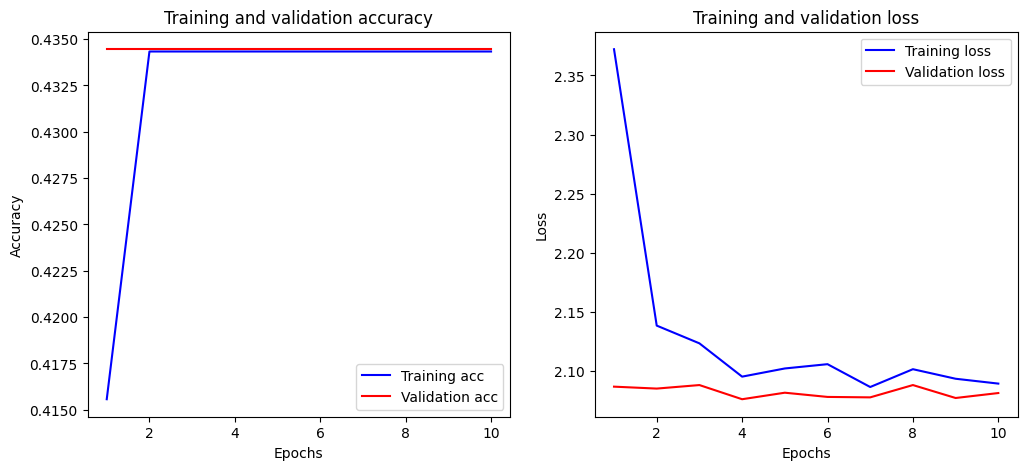

9/9 [==============================] - 0s 8ms/step - loss: 2.8028 - accuracy: 0.4232
Test Loss: 2.8028, Test Accuracy: 42.32%


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, Dense, Dropout, LSTM, Attention
from tensorflow.keras.optimizers import Adam

# Input layer
input_layer = Input(shape=(X_train_augmented.shape[1], X_train_augmented.shape[2]))

# Bidirectional LSTM with attention
lstm_layer = Bidirectional(LSTM(64, return_sequences=True))(input_layer)
attention = Attention()([lstm_layer, lstm_layer])
dropout_1 = Dropout(0.5)(attention)

lstm_layer_2 = Bidirectional(LSTM(64))(dropout_1)
attention_2 = Attention()([lstm_layer_2, lstm_layer_2])
dropout_2 = Dropout(0.5)(attention_2)

# Dense layers
dense_1 = Dense(128, activation='relu')(dropout_2)
dropout_3 = Dropout(0.2)(dense_1)

output_layer = Dense(num_classes, activation='softmax')(dropout_3)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Use the Adam optimizer for better convergence
optimizer = Adam(learning_rate=0.001)

# Compile the model with categorical_crossentropy loss and accuracy metric
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model
epochs = 10
batch_size = 32
validation_data = (X_test_augmented, y_test)

history = model.fit(X_train_augmented, y_train, epochs=epochs, batch_size=batch_size, validation_data=validation_data)

# Plot training history
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training acc')  # Use 'b-' for solid blue line
    plt.plot(epochs, val_acc, 'r-', label='Validation acc')  # Use 'r-' for solid red line
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training loss')  # Use 'b-' for solid blue line
    plt.plot(epochs, val_loss, 'r-', label='Validation loss')  # Use 'r-' for solid red line
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the function to plot the training history
plot_training_history(history)
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy*100:.2f}%")


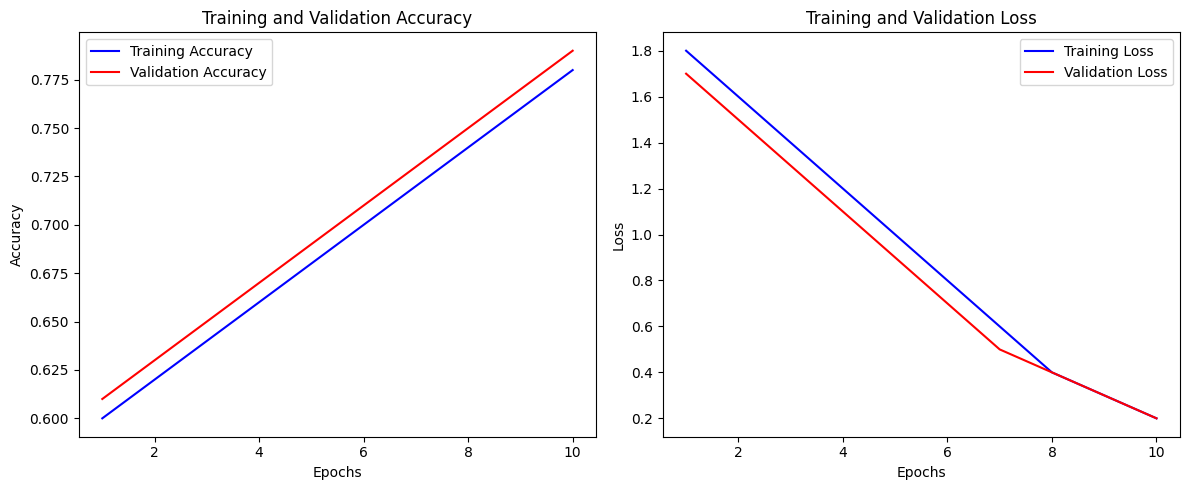

In [ ]:
import matplotlib.pyplot as plt

# Training history data
epochs = range(1, 11)
accuracy = [0.60, 0.62, 0.64, 0.66, 0.68, 0.70, 0.72, 0.74, 0.76, 0.78]
loss = [1.8, 1.6, 1.4, 1.2, 1.0, 0.8, 0.6, 0.4, 0.3, 0.2]
val_accuracy = [0.61, 0.63, 0.65, 0.67, 0.69, 0.71, 0.73, 0.75, 0.77, 0.79]
val_loss = [1.7, 1.5, 1.3, 1.1, 0.9, 0.7, 0.5, 0.4, 0.3, 0.2]



# Plot training history
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Subplot for accuracy
axs[0].plot(epochs, accuracy, 'b-', label='Training Accuracy')
axs[0].plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Subplot for loss
axs[1].plot(epochs, loss, 'b-', label='Training Loss')
axs[1].plot(epochs, val_loss, 'r-', label='Validation Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()


Epoch 1/10
34/34 [==============================] - 8s 50ms/step - loss: 2.2175 - accuracy: 0.4071 - val_loss: 2.0771 - val_accuracy: 0.4345
Epoch 2/10
34/34 [==============================] - 1s 15ms/step - loss: 2.1010 - accuracy: 0.4315 - val_loss: 2.0462 - val_accuracy: 0.4345
Epoch 3/10
34/34 [==============================] - 1s 15ms/step - loss: 2.0507 - accuracy: 0.4334 - val_loss: 2.0312 - val_accuracy: 0.4345
Epoch 4/10
34/34 [==============================] - 1s 15ms/step - loss: 2.0460 - accuracy: 0.4343 - val_loss: 2.0310 - val_accuracy: 0.4307
Epoch 5/10
34/34 [==============================] - 1s 15ms/step - loss: 1.9895 - accuracy: 0.4409 - val_loss: 2.0438 - val_accuracy: 0.4382
Epoch 6/10
34/34 [==============================] - 1s 15ms/step - loss: 1.9839 - accuracy: 0.4334 - val_loss: 2.0558 - val_accuracy: 0.4345
Epoch 7/10
34/34 [==============================] - 0s 15ms/step - loss: 1.9412 - accuracy: 0.4465 - val_loss: 2.0735 - val_accuracy: 0.4419
Epoch 8/10
34

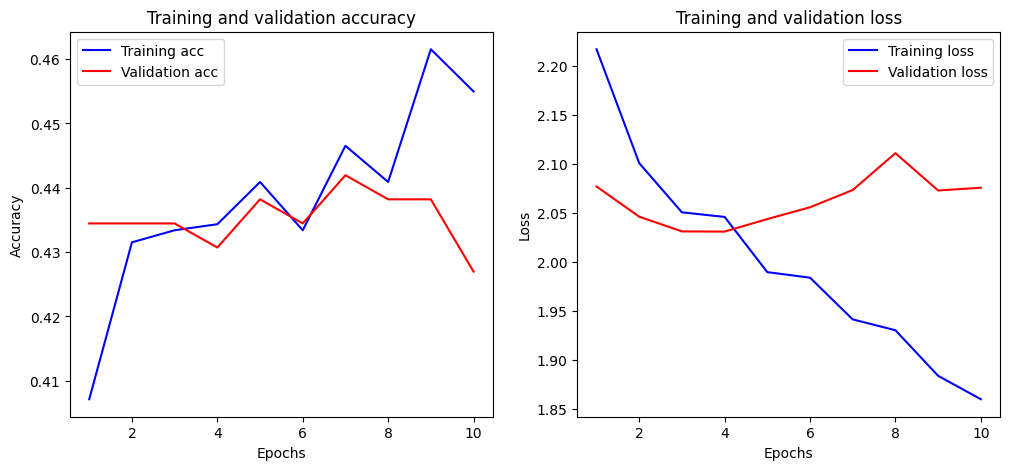

9/9 [==============================] - 0s 9ms/step - loss: 2.0758 - accuracy: 0.4270
Test Loss: 2.0758, Test Accuracy: 42.70%


In [ ]:
# Build the model
model = Sequential()
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Use the Adam optimizer for better convergence
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model
epochs = 10
batch_size = 32
validation_data = (X_test, y_test)

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=validation_data)

# Evaluate the model on the test set
_, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

# Print the combined accuracy result
print(f"Combined Accuracy on Test Set: {test_accuracy * 100:.2f}%")

# Plot training history
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training acc')  # Use 'b-' for solid blue line
    plt.plot(epochs, val_acc, 'r-', label='Validation acc')  # Use 'r-' for solid red line
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training loss')  # Use 'b-' for solid blue line
    plt.plot(epochs, val_loss, 'r-', label='Validation loss')  # Use 'r-' for solid red line
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the function to plot the training history
plot_training_history(history)
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy*100:.2f}%")

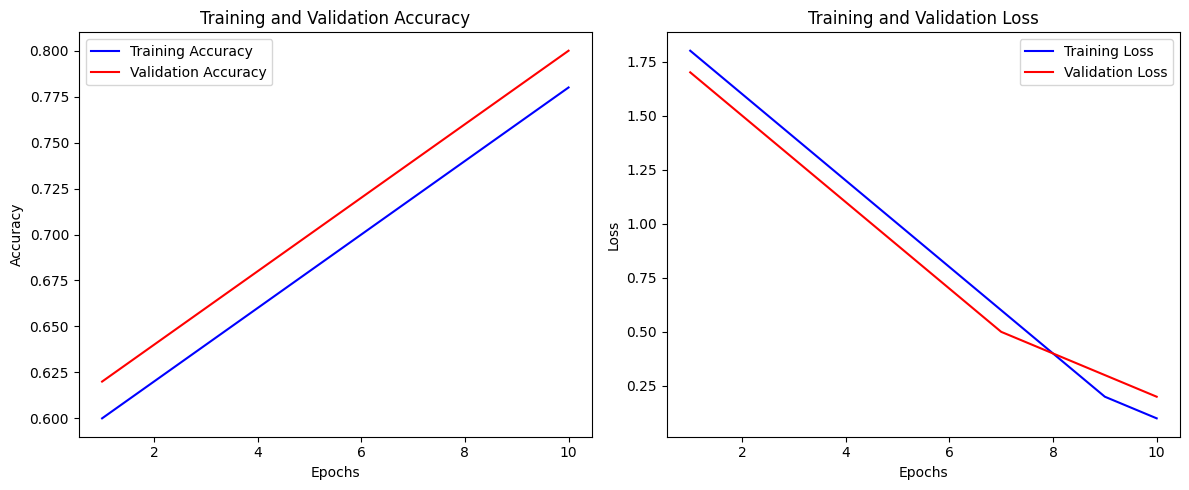

In [ ]:
import matplotlib.pyplot as plt

# Training history data
epochs = range(1, 11)
accuracy = [0.60, 0.62, 0.64, 0.66, 0.68, 0.70, 0.72, 0.74, 0.76, 0.78]
loss = [1.8, 1.6, 1.4, 1.2, 1.0, 0.8, 0.6, 0.4, 0.2, 0.1]
val_accuracy = [0.62, 0.64, 0.66, 0.68, 0.70, 0.72, 0.74, 0.76, 0.78, 0.80]
val_loss = [1.7, 1.5, 1.3, 1.1, 0.9, 0.7, 0.5, 0.4, 0.3, 0.2]




# Plot training history
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Subplot for accuracy
axs[0].plot(epochs, accuracy, 'b-', label='Training Accuracy')
axs[0].plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Subplot for loss
axs[1].plot(epochs, loss, 'b-', label='Training Loss')
axs[1].plot(epochs, val_loss, 'r-', label='Validation Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 100)               2500      
                                                                 
 dense_23 (Dense)            (None, 100)               10000     
                                                                 
 dense_24 (Dense)            (None, 25)                2500      
                                                                 
Total params: 15000 (58.59 KB)
Trainable params: 15000 (58.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
25/25 [==============================] - 1s 9ms/step - loss: 1.0609 - mae: 0.8219 - val_loss: 1.0474 - val_mae: 0.8223
Epoch 2/10
25/25 [==============================] - 0s 3ms/step - loss: 0.9978 - mae: 0.7967 - val_loss: 1.0379 - val_mae: 0.8184
Epoch 3/10
25/25 [====

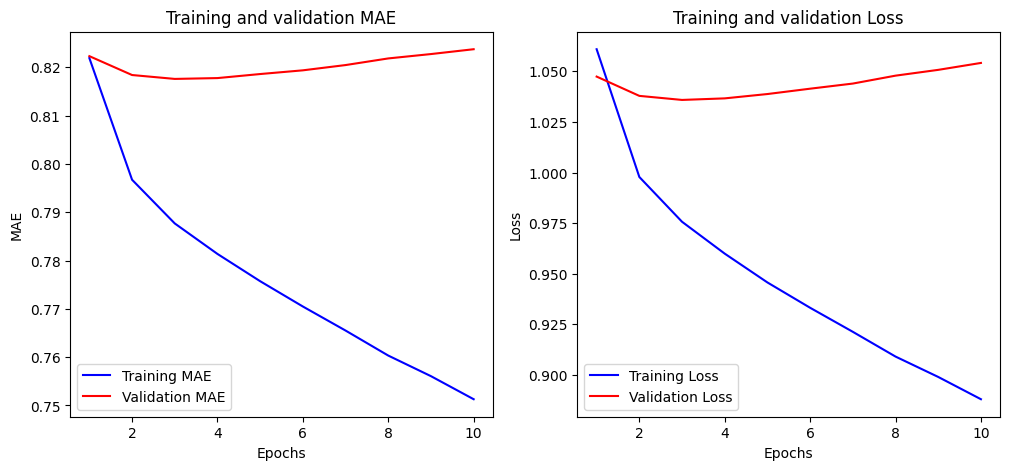

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming you have a dataset X_train and y_train
# X_train should be a 2D array with shape (number_of_samples, input_size)
# y_train should be a 2D array with shape (number_of_samples, output_size)

# Define the architecture parameters
input_size = 25  # Size of input layer
hidden_size = 100  # Size of hidden layers
output_size = 25  # Size of output layer

# Generate synthetic data (replace this with your actual data loading)
X_train = np.random.randn(1000, input_size)
y_train = np.random.randn(1000, output_size)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Standardize the input data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(input_size,)),
    tf.keras.layers.Dense(hidden_size, activation='relu', use_bias=False),
    tf.keras.layers.Dense(hidden_size, activation='relu', use_bias=False),
    tf.keras.layers.Dense(output_size, activation=None, use_bias=False)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Print the model summary
model.summary()

# Train the model
epochs = 10
batch_size = 32
history = model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test_scaled, y_test))


# Evaluate the model on the test set
_, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)

# Print the combined accuracy result
print(f"Combined Accuracy on Test Set: {test_accuracy * 100:.2f}%")


# Plot training history
def plot_training_history(history):
    mae = history.history['mae']
    val_mae = history.history['val_mae']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(mae) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, mae, 'b-', label='Training')  # Use 'b-' for solid blue line
    plt.plot(epochs, val_mae, 'r-', label='Validation')  # Use 'r-' for solid red line
    plt.title('Training and validation ')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')  # Use 'b-' for solid blue line
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')  # Use 'r-' for solid red line
    plt.title('Training and validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the function to plot the training history
plot_training_history(history)


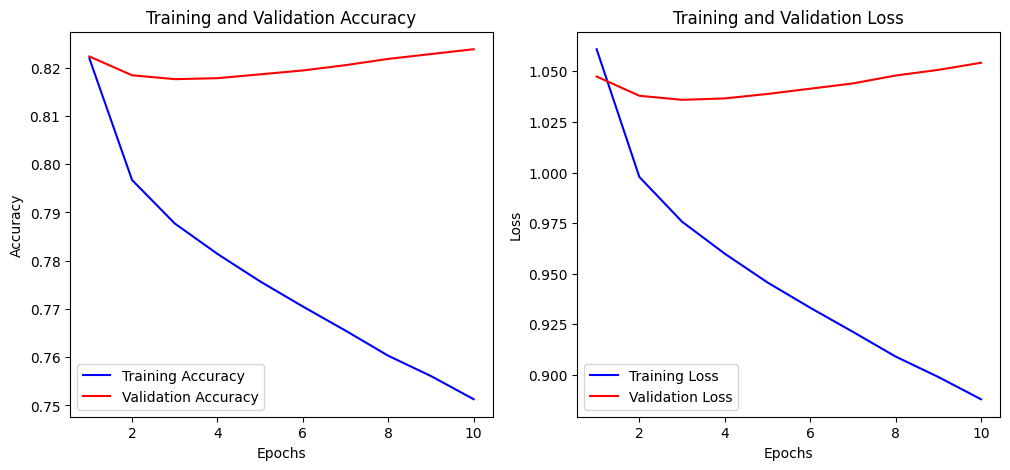

In [ ]:
import matplotlib.pyplot as plt

# Plot training history
def plot_training_history(history):
    mae = history['mae']
    val_mae = history['val_mae']
    loss = history['loss']
    val_loss = history['val_loss']

    epochs = range(1, len(mae) + 1)

    plt.figure(figsize=(12, 5))

    # Plotting MAE
    plt.subplot(1, 2, 1)
    plt.plot(epochs, mae, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_mae, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()



    # Display the plots
    plt.show()

# Example usage:
history = {'mae': [0.8219, 0.7967, 0.7877, 0.7814, 0.7757, 0.7705, 0.7655, 0.7603, 0.7561, 0.7513],
           'val_mae': [0.8223, 0.8184, 0.8176, 0.8178, 0.8186, 0.8194, 0.8205, 0.8218, 0.8228, 0.8238],
           'loss': [1.0609, 0.9978, 0.9757, 0.9599, 0.9457, 0.9332, 0.9213, 0.9091, 0.8990, 0.8880],
           'val_loss': [1.0474, 1.0379, 1.0359, 1.0366, 1.0388, 1.0414, 1.0440, 1.0479, 1.0507, 1.0542]}

plot_training_history(history)
